<h1>Multitaper Power Spectral Density Computation & Average Welch Periodogram Algorithm</h1>

One of the features that can be used to distinguish spindles from non-spindles is the "spindle band power to delta + theta band power ratio" (SDT Ratio). That is:

\begin{equation}
    \text{SDT Ratio} = \frac{\text{Average Spindle Band Power}}{\text{Average Delta Power} + \text{Average Theta Power}}
\end{equation}

During the frame acquisition stage and the QPS parameter feature extraction, we can create a separate task that takes the frame of the raw EEG epoch and computes the multitaper power spectrum. This method uses <i>Slepian sequences</i> (DPSS) which serve as bandpass filters. These sequences are convolved with the acquired frame to produce the filtered or 'tapered' data. The single-taper power spectrum can then be computed for each tapered signal with which the <b>average</b> PSD can then be calculated. The process is summarised in the diagram below:

<img src='https://raphaelvallat.com/images/tutorials/bandpower/prerau_article.jpg' width="60%" height="60%">

The area under the PSD at each of the required spindle bands can then be computed using integration via Simpson's rule. Once each area is calculated, the SDT Ratio can be calculated.

<h3>Advantages Of The Multitaper Method</h3>

Each Slepian sequence used for the multi-taper PSD computation is <i>orthogonal</i> to all other sequences used. This means that each tapered sequence is statistically independent from all other tapered signals produced.

<h3>More Information</h3>

More information on how to compute the average PSD of different components in the EEG signal is discussed on Raphael Vallat's website below:

https://raphaelvallat.com/bandpower.html

In [298]:
# Import necessary libraries first:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

# Package for processing EDF++ files
import mne

<h2>Using Sample EEG Data From Raphael Vallat</h2>

The sample EEG data can be found in Raphael Vallat's personal homepage where he goes through different methods of PSD computation.

https://raphaelvallat.com/bandpower.html

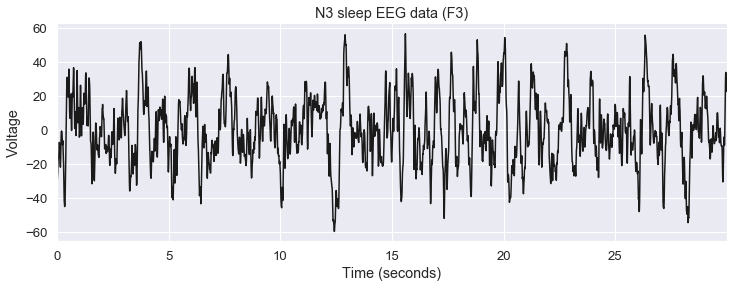

In [299]:
import numpy as np
data = np.loadtxt('sample_eeg.txt')

# Define sampling frequency and time vector
sf = 100.0
time = np.arange(data.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title('N3 sleep EEG data (F3)')
sns.despine()

<h3>Multitaper PSD Computation</h3>

In [300]:
from scipy.signal import welch
from scipy.integrate import simps
from mne.time_frequency import psd_array_multitaper

def bandpower(data, sf, band, relative=False):
    
    # Get the lower and upper cutoff frequency as individual variables.
    band = np.asarray(band)
    low, high = band
    
    # Computing the PSD. Frequency-axis goes up to the Nyquist frequency which is Fs/2.
    psd, freqs = psd_array_multitaper(data, sf, adaptive=True, normalization='full', verbose=0)

    # The frequency resolution (df) necessary for integral calculation via simpson's rule
    df = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=df)
    
    if relative == True:
        bp = bp / simps(psd, dx=df)
        
    # Return the final bandpower value (Relative value recommended)
    return bp


In [301]:
# Compute the spindle band power:
spindle_bp = bandpower(data, sf, [9, 16], relative = True)

# Compute the delta band power:
delta_bp = bandpower(data, sf, [0.5, 4], relative = True)

# Compute the theta band power:
theta_bp = bandpower(data, sf, [4,7], relative = True)

# Print out the relative powers:
print("Relative Spindle Power = %.3f" %spindle_bp)
print("Relative Delta Power = %.3f" %delta_bp)
print("Relative Theta Power = %.3f" %theta_bp)

Relative Spindle Power = 0.039
Relative Delta Power = 0.790
Relative Theta Power = 0.081


In [302]:
# Compute the SDT Ratio:
sdt_ratio = spindle_bp / (delta_bp + theta_bp)

# Print out the SDT Ratio:
print("SDT Ratio (%) = {}%".format(round(sdt_ratio, 3) * 100))

SDT Ratio (%) = 4.5%


The above results show that spindle power is much more insignificant than the power of the delta and theta frequency components in the sample EEG. What we can do is peform a similar computation for EEG data from MASS and compare the results from that from Raphael's sample EEG data.

<h2>PSD Computation Using MASS Dataset</h2>

In [303]:
# Necessary file names ready to go:
path = r"C:\Users\Jason Ha\Documents\University\4th Year\Thesis Project (Repo)\Jupyter Notebooks\Active Projects\mass_data\01-02-0001_PSG"
file = r"01-02-0001_PSG.edf"
scorer_annot_1 = r"01-02-0001_Annotations.csv"
scorer_annot_2 = r"01-02-0001_Annotations2.csv"
sleep_stages_filename = r"01-02-0001_Stages.edf"

# Load raw MNE file. Preload = False (Save hard drive memory):
raw_file = path + "\\" + file
raw = mne.io.read_raw_edf(raw_file, preload=False, verbose=False)

# Load annotations per the sleep stage EDF file into workspace
sleep_stages_file = path + "\\" + sleep_stages_filename
stages = mne.read_annotations(sleep_stages_file)

# Set the annotations onto the raw file:
raw.set_annotations(stages)

# Get the event and event_id from the annotations:
event, event_id = mne.events_from_annotations(raw)

# Create epochs from the event and event_id
epochs = mne.Epochs(raw, event, event_id, tmin=0.0, tmax=20, baseline=None) # 20 second epochs (based off stage annotations)

# Create dataframe from epochs
epochs_df = epochs.to_data_frame()

<ipython-input-303-9c3d9df424b6>:10: RuntimeWarning: 2 channel names are too long, have been truncated to 15 characters:
['EOG Lower Vertic', 'EOG Upper Vertic']
  raw = mne.io.read_raw_edf(raw_file, preload=False, verbose=False)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage ?', 'Sleep stage R', 'Sleep stage W']
1419 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 1419 events and 5121 original time points ...
0 bad epochs dropped
Converting "time" to "<class 'numpy.int64'>"...


In [304]:
epochs_df.head()

channel                   EOG Right Horiz  Resp nasal  EEG Pz-LER  \
condition     epoch time                                            
Sleep stage ? 0     0          -32.573788   20.132534 -257.963051   
                    4          -31.816386   19.894342 -257.963051   
                    8          -30.806517   19.822884 -257.963051   
                    12         -28.534311   19.965799 -257.963051   
                    16         -32.321321   20.251629 -257.963051   

channel                   EEG Fp1-LER  EMG Chin  EEG Fpz-LER  EEG Cz-LER  \
condition     epoch time                                                   
Sleep stage ? 0     0       -4.917746 -1.832980    -8.070029    1.344633   
                    4       -3.529177  2.874355    -5.121987    5.323181   
                    8       -5.170213  2.824788    -8.198205    1.087952   
                    12      -6.306314 -6.617764    -9.608139   -1.727513   
                    16      -6.053847 -7.633892   -11.915302   -6.347763   

channel                   EEG O1-LER  EEG C4-LER  EEG F3-LER  ...  EEG F8-LER  \
condition     epoch time                                      ...               
Sleep stage ? 0     0     -12.849489   -3.166658   -4.515893  ...  -21.353666   
                    4      -9.025625    0.124147   -2.478145  ...  -18.565971   
                    8     -13.612672   -3.801030   -4.897970  ...  -22.874228   
                    12    -13.485475   -4.435402   -4.897970  ...  -21.860520   
                    16    -12.849489   -6.084769   -6.298922  ...  -22.240660   

channel                   EOG Upper Verti  EEG T6-LER  EEG T4-LER  EEG F7-LER  \
condition     epoch time                                                        
Sleep stage ? 0     0          -71.761064  -11.318982  -14.040031    0.954687   
                    4          -67.964469   -6.939513   -9.458811    1.593110   
                    8          -67.205149   -8.065662  -10.983238    0.954687   
                    12         -64.420979   -5.312853   -8.696598    2.231534   
                    16         -63.408554   -3.561065   -8.061420    0.954687   

channel                   EEG P3-LER       ECG I  EEG A2-LER  EEG F4-LER  \
condition     epoch time                                                   
Sleep stage ? 0     0      -5.192701 -242.737900  -46.938327   -8.973465   
                    4       0.959612 -257.192393  -40.960060   -7.190436   
                    8      -3.780958 -255.987852  -40.069680  -11.265931   
                    12     -3.909298 -246.351523  -44.521581  -12.539523   
                    16     -5.449381 -253.578770  -48.854234  -14.457872   

channel                   EEG T3-LER  
condition     epoch time              
Sleep stage ? 0     0     -12.428005  
                    4     -10.120842  
                    8     -10.505369  
                    12     -8.710908  
                    16     -8.454557  

[5 rows x 27 columns]

In [305]:
eeg_epochs_df = epochs_df[['EEG C3-LER']]
eeg_epochs = eeg_epochs_df.loc["Sleep stage 2", :]
eeg_epochs

channel      EEG C3-LER
epoch time             
13    0       -4.456643
      4       -6.138015
      8       -6.138015
      12      -4.973989
      16      -1.740580
...                 ...
1409  19983    4.976825
      19987    4.718152
      19991    6.658197
      19995    6.270188
      19999    7.692888

[3815145 rows x 1 columns]

In [387]:
scorer_1 = path + "\\" + scorer_annot_1
s1_df = pd.read_csv(scorer_1)
s1_df.columns = ['start', 'duration']
s1_df['end'] = s1_df['start'] + s1_df['duration']

# Make a temporary column for the start times rounded to the nearest integer:
s1_df['start_floor'] = s1_df['start'].astype('int32')

scorer_2 = path + "\\" + scorer_annot_2
s2_df = pd.read_csv(scorer_2)
s2_df.columns = ['start', 'duration']
s2_df['end'] = s2_df['start'] + s2_df['duration']

# Make a temporary column for the start times rounded to the nearest integer:
s2_df['start_floor'] = s2_df['start'].astype('int32')

# Get the 'inner join' of the two scorers' dataframes in order to get the ground truth.
scorer_inner = pd.merge(s1_df, s2_df, how='inner', on=['start_floor'])
scorer_inner.head()

# Take the mean of the start (onset) tie, duration of the spindle and the end time for each scorer:
scorer_final = pd.DataFrame()
scorer_final['start'] = (scorer_inner['start_x'] + scorer_inner['start_y']) / 2
scorer_final['duration'] = (scorer_inner['duration_x'] + scorer_inner['duration_y']) / 2
scorer_final['end'] = (scorer_inner['end_x'] + scorer_inner['end_y']) / 2

scorer_final[scorer_final.start >= 3500].head(20)

,start,duration,end
14,4068.695623,1.064386,4069.760009
15,4077.390181,0.511686,4077.901867
16,4083.817717,0.505829,4084.323546
17,4182.310436,0.949158,4183.259594
18,4207.885096,0.880803,4208.765899
19,4217.429173,1.054621,4218.483794
20,4243.285470,1.181565,4244.467035
21,4257.399570,0.736281,4258.135851
22,4279.493854,1.119072,4280.612926
23,4283.493094,1.134693,4284.627787


In [307]:
# Get all the unique epochs from the dataframe:
temp = epochs_df.reset_index(drop=False)
tmp = temp[temp['condition'] == 'Sleep stage 2']
epoch_list = tmp['epoch'].unique()

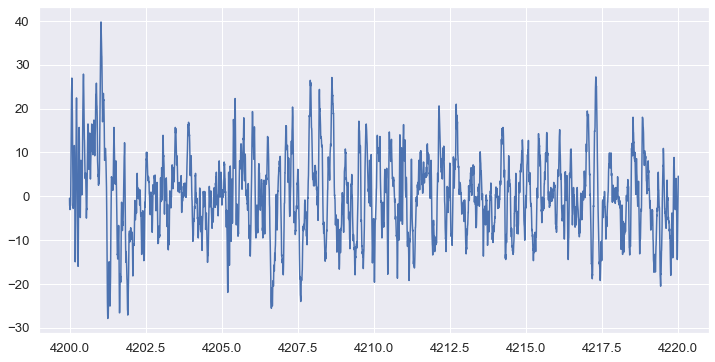

In [350]:
epoch = epoch_list[51]
example = eeg_epochs.loc[epoch]
signal = example['EEG C3-LER']
signal.interpolate(method='time').fillna(0)

# Make time axis reflect the true time-value it was extracted from (from full EEG recording)
time = example.index.values / 1000
time = time + (epoch * 20)

fig = plt.figure(figsize=(12,6))
plt.plot(time, signal)
plt.show()

In [418]:
# Set parameters for window length (Tw) and stride. These parameters should be tuneable by the user.
Tw = 0.5     # (1.0 second window length)
stride = 0.25 # (Half a second overlap)

# Compute the frame length based on time-vector from dataframe. Since MNE creates a timestep of 4ms, the frame length
# in samples is (Tw * 1000) / 4. The 1000 is the convert to milliseconds and the divide by 4 converts the time to
# upper array index for the time and signal array.
frame_len = int(Tw * 1000 / 4)
shift = int(stride * 1000 / 4)

In [419]:
csf_ub = int(np.ceil((len(time) - frame_len) / shift))
csf_ub

81

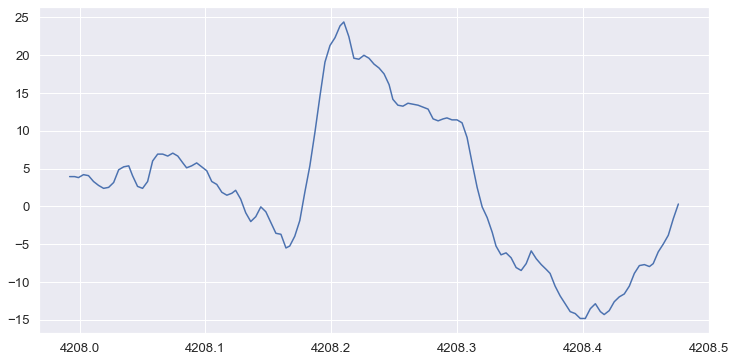

In [428]:
curr_shift_factor = 33

fig = plt.figure(figsize=(12,6))
time_6 = time[0 + (curr_shift_factor*shift) : frame_len + (curr_shift_factor*shift)]
signal_6 = signal[0 + (curr_shift_factor*shift) : frame_len + (curr_shift_factor*shift)]
plt.plot(time_6, signal_6)
plt.ticklabel_format(useOffset=False)
plt.show()

In [429]:
# Take the time-vector from frame 6 and check if any of the spindle onset times fall in the time-vector:
condition = (scorer_final['start'] > min(time_6)) & (scorer_final['start'] < max(time_6))

# If this is true, we should see a particular spindle extracted from the annotations:
fall_in = scorer_final[condition]
fall_in

,start,duration,end


<h3>Algorithm To Determine Spindle/Non-Spindle</h3>

Assume that the frames are accessed in ORDER. This is because we need to keep track of the spindle onset and offset to ensure we are labelling the captured frame appropriately. Only when we completely move past the offset of a spindle can we label the frame as a non-spindle.

In [ ]:
################################################################################################
# Setup flags for onset and offset detection in frame. Assume sequential movement of the frame.
# To classify as a spindle there are a few cases:
#     Onset flag has to be within MORE than 50% of the frame (from end of frame)
#     Offset flag has to be within LESS than 50% of the frame (from end of frame)
################################################################################################

# Label flag. When certain conditions are met for the flags, associated the frame with a label for manual classification
label = 0;

# Need to check if any annotations were caught by the frame in the first place.
if ((len(fall_in) == 0) ):
    
    
    
else:
    #####################
    # Conditional block #
    #####################

    if ():

    elif ():





<h3>Algorithm Plotting Spindles With Respect To Annotations</h3>

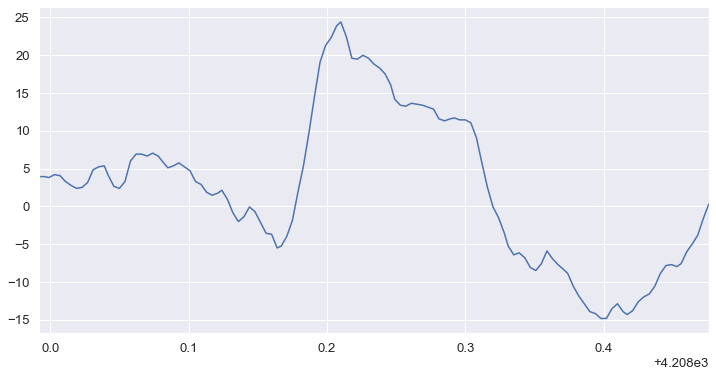

In [433]:
fig = plt.figure(figsize=(12,6))
plt.plot(time_6, signal_6)
plt.xlim([min(time_6), max(time_6)])

if (len(fall_in) != 0):
    
    # Plotting the onset IF it lies in the frame
    if (float(fall_in['start']) >= min(time_6)):
        plt.axvline(float(fall_in['start']), color='red', label='Spindle Onset')
    
    # Plotting the offset IF it lies in the frame:
    if (float(fall_in['end']) <= max(time_6)):
        plt.axvline(float(fall_in['end']), color='blue', label='Spindle End')
    
    # Plotting the shaded area between the onset and/or offset annotation
    if ((float(fall_in['start']) >= min(time_6)) & (float(fall_in['end']) <= max(time_6))):
        plt.axvspan(float(fall_in['start']), float(fall_in['end']), color='red', alpha=0.15)
    elif((float(fall_in['start']) >= min(time_6)) & (float(fall_in['end']) >= max(time_6))):
        plt.axvspan(float(fall_in['start']), float(max(time_6)), color='red', alpha=0.15)
    elif((float(fall_in['start']) <= min(time_6)) & (float(fall_in['end']) <= max(time_6))):
        plt.axvspan(float(min(time_6)), float(fall_in['end']), color='red', alpha=0.15)
    
    plt.legend()
    
plt.show()

In [434]:
# Define the sampling rate for the MASS dataset:
sampling_rate = raw.info['sfreq']

# Compute the spindle band power:
spindle_bp_mass = bandpower(signal_6, sampling_rate, [11, 16], relative = True)

# Compute the delta band power:
delta_bp_mass = bandpower(signal_6, sampling_rate, [0.5, 4], relative = True)

# Compute the theta band power:
theta_bp_mass = bandpower(signal_6, sampling_rate, [4,7], relative = True)

In [425]:
# Print out the relative powers:
print("Relative Spindle Power = %.3f" %spindle_bp_mass)
print("Relative Delta Power = %.3f" %delta_bp_mass)
print("Relative Theta Power = %.3f" %theta_bp_mass)

Relative Spindle Power = 0.033
Relative Delta Power = 0.000
Relative Theta Power = 0.166


In [426]:
# Compute the SDT Ratio:
sdt_ratio_mass = spindle_bp_mass / (delta_bp_mass + theta_bp_mass)

# Print out the SDT Ratio:
print("SDT Ratio (%) = {}%".format(round(sdt_ratio_mass, 3) * 100))

SDT Ratio (%) = 20.1%


In [2]:
import numpy as np
a1 = np.array([1])
a2 = np.array([])

In [6]:
len(a1) and len(a2)

0